# K-SVD Image Denoising Implementation

This notebook implements K-SVD denoising for images, extending the regular SVD approach by using dictionary learning on image patches.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.util import view_as_windows
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
import cv2
from scipy import ndimage
import time

## Load and Prepare Test Image

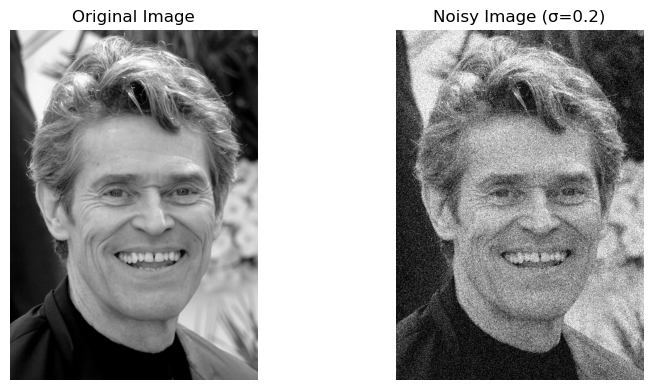

In [25]:
# Load an example image
def load_grayscale_image(path):
    img = Image.open(path).convert('L')
    img_array = np.array(img) / 255.0  # Normalize to [0,1]
    return img_array

# load an image
original_image = load_grayscale_image('images/Willem_Dafoe_Cannes_2019.jpg')

# Add noise to create noisy image
def add_noise(image, noise_level=0.1):
    noise = np.random.normal(0, noise_level, image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0, 1)

noisy_image = add_noise(original_image, noise_level=0.2)

# Display the original and noisy images
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(noisy_image, cmap='gray')
plt.title('Noisy Image (σ=0.2)')
plt.axis('off')

# We'll fill the third subplot after denoising
plt.tight_layout()

## K-SVD Denoising Implementation

K-SVD denoising works through these key steps:
1. Break the image into overlapping patches
2. Learn a dictionary that can sparsely represent these patches
3. For each patch, find a sparse representation using the dictionary
4. Reconstruct the denoised image from these sparse representations

Unlike standard SVD which works on the whole image, K-SVD operates on local patches and iteratively updates both the dictionary and the sparse coefficients.

In [26]:
def initialize_dictionary(patch_size, dict_size):
    """Initialize an overcomplete dictionary for K-SVD"""
    # Create random dictionary and normalize columns
    dict_atoms = np.random.randn(patch_size, dict_size)
    # Normalize each column (atom) to have unit L2 norm
    dict_atoms = dict_atoms / np.sqrt(np.sum(dict_atoms**2, axis=0))
    return dict_atoms

def orthogonal_matching_pursuit(y, D, sparsity):
    """Sparse coding using Orthogonal Matching Pursuit (OMP)"""
    n_samples = y.shape[1]
    n_atoms = D.shape[1]
    x = np.zeros((n_atoms, n_samples))
    
    for i in range(n_samples):
        signal = y[:, i].copy()
        residual = signal.copy()
        indices = []
        
        for j in range(sparsity):
            # Find the atom most correlated with the residual
            correlations = np.abs(D.T @ residual)
            best_atom = np.argmax(correlations)
            indices.append(best_atom)
            
            # Solve least squares to get coefficients for selected atoms
            selected_atoms = D[:, indices]
            coeffs, _, _, _ = np.linalg.lstsq(selected_atoms, signal, rcond=None)
            
            # Update residual
            residual = signal - selected_atoms @ coeffs
            
            # If residual is very small, stop
            if np.sum(residual**2) < 1e-6:
                break
        
        # Set the coefficients in the sparse representation
        x[indices, i] = coeffs
    
    return x

def update_dictionary_atom(Y, D, X, k):
    """Update a single dictionary atom and its corresponding coefficients"""
    # Find examples that use this atom
    indices = np.nonzero(X[k, :])[0]
    
    if len(indices) == 0:
        # If no example uses this atom, replace with a random normalized example
        rand_idx = np.random.randint(0, Y.shape[1])
        D[:, k] = Y[:, rand_idx].copy()
        D[:, k] = D[:, k] / np.linalg.norm(D[:, k])
        return D, X
    
    # Calculate error matrix excluding current atom
    X_k = X.copy()
    X_k[k, :] = 0  # Zero out contributions from current atom
    error = Y - D @ X_k
    error_k = error[:, indices]
    
    # SVD of the error matrix to get the updated atom
    U, S, Vh = np.linalg.svd(error_k, full_matrices=False)
    D[:, k] = U[:, 0]  # First left singular vector is the updated atom
    X[k, indices] = S[0] * Vh[0, :]  # Update coefficients
    
    return D, X

def k_svd_dictionary_learning(Y, n_atoms, sparsity, max_iter=10):
    """K-SVD dictionary learning algorithm"""
    n_features, n_samples = Y.shape
    
    # Initialize dictionary
    D = initialize_dictionary(n_features, n_atoms)
    
    for iteration in range(max_iter):
        print(f"Dictionary learning iteration {iteration+1}/{max_iter}")
        
        # Sparse coding step
        X = orthogonal_matching_pursuit(Y, D, sparsity)
        
        # Dictionary update step
        for k in range(n_atoms):
            D, X = update_dictionary_atom(Y, D, X, k)
    
    return D, X

def k_svd_denoise(noisy_image, patch_size=8, dict_size=256, sparsity=4, max_iter=10, overlap=4):
    """Denoise an image using K-SVD"""
    start_time = time.time()
    
    # Extract overlapping patches
    patches = extract_patches_2d(noisy_image, (patch_size, patch_size))
    patches_vec = patches.reshape(patches.shape[0], -1).T  # Each column is a patch vector
    
    print(f"Extracted {patches.shape[0]} patches of size {patch_size}x{patch_size}")
    
    # Learn dictionary and get sparse representation
    dictionary, sparse_codes = k_svd_dictionary_learning(
        patches_vec, dict_size, sparsity, max_iter)
    
    # Reconstruct denoised patches
    denoised_patches_vec = dictionary @ sparse_codes
    denoised_patches = denoised_patches_vec.T.reshape(patches.shape)
    
    # Reconstruct image from patches
    denoised_image = reconstruct_from_patches_2d(denoised_patches, noisy_image.shape)
    
    # Clip values to valid range
    denoised_image = np.clip(denoised_image, 0, 1)
    
    elapsed_time = time.time() - start_time
    print(f"K-SVD denoising completed in {elapsed_time:.2f} seconds.")
    
    return denoised_image, dictionary

## Apply K-SVD Denoising and Visualize Results

Extracted 62001 patches of size 8x8
Dictionary learning iteration 1/5
Dictionary learning iteration 2/5
Dictionary learning iteration 3/5
Dictionary learning iteration 4/5
Dictionary learning iteration 5/5
K-SVD denoising completed in 73.63 seconds.
PSNR of noisy image: 14.29 dB
PSNR of denoised image: 25.50 dB
PSNR improvement: 11.21 dB


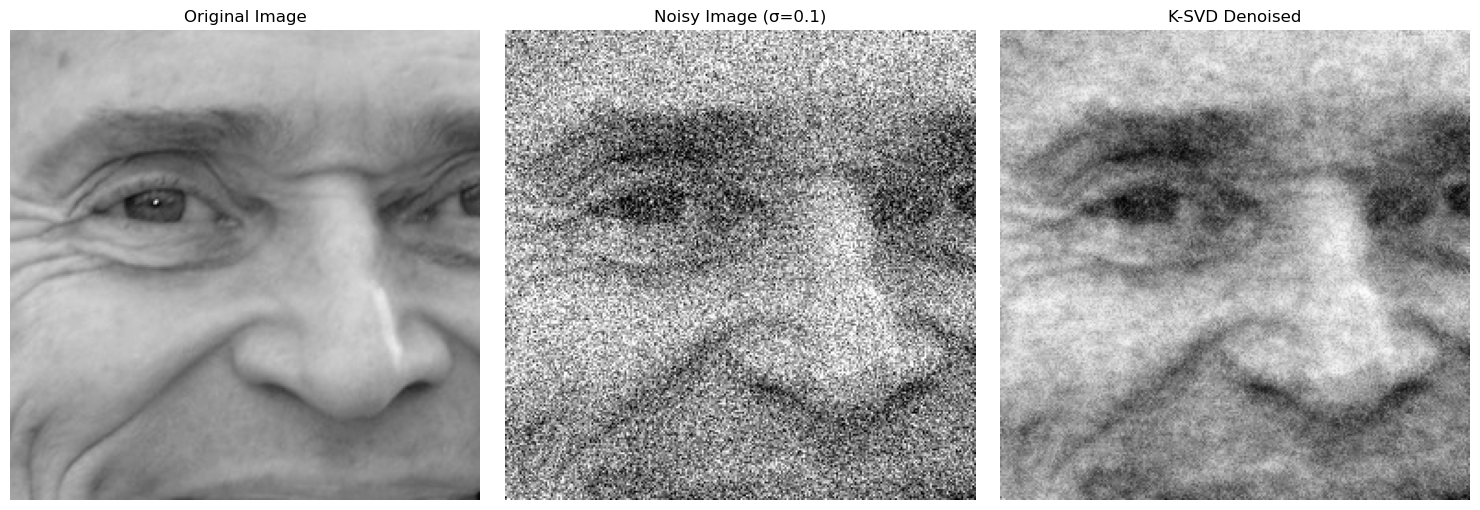

In [27]:
# For faster execution in this demo, use a smaller portion of the image
# Remove these lines if you want to process the full image
height, width = original_image.shape
crop_size = min(256, min(height, width))  # Use at most 128x128 for demo
start_h = (height - crop_size) // 2
start_w = (width - crop_size) // 2
original_image_cropped = original_image[start_h:start_h+crop_size, start_w:start_w+crop_size]
noisy_image_cropped = noisy_image[start_h:start_h+crop_size, start_w:start_w+crop_size]

# Run K-SVD denoising
denoised_image, learned_dictionary = k_svd_denoise(
    noisy_image_cropped, 
    patch_size=8, 
    dict_size=128,  # Reduced from 256 for faster execution
    sparsity=4, 
    max_iter=5      # Reduced from 10 for faster execution
)

# Display the original, noisy, and denoised images
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(original_image_cropped, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(noisy_image_cropped, cmap='gray')
plt.title('Noisy Image (σ=0.1)')
plt.axis('off')

plt.subplot(133)
plt.imshow(denoised_image, cmap='gray')
plt.title('K-SVD Denoised')
plt.axis('off')

plt.tight_layout()

# Calculate PSNR as a quantitative measure of denoising performance
def calculate_psnr(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

psnr_noisy = calculate_psnr(original_image_cropped, noisy_image_cropped)
psnr_denoised = calculate_psnr(original_image_cropped, denoised_image)

print(f"PSNR of noisy image: {psnr_noisy:.2f} dB")
print(f"PSNR of denoised image: {psnr_denoised:.2f} dB")
print(f"PSNR improvement: {psnr_denoised - psnr_noisy:.2f} dB")

## Visualize the Learned Dictionary

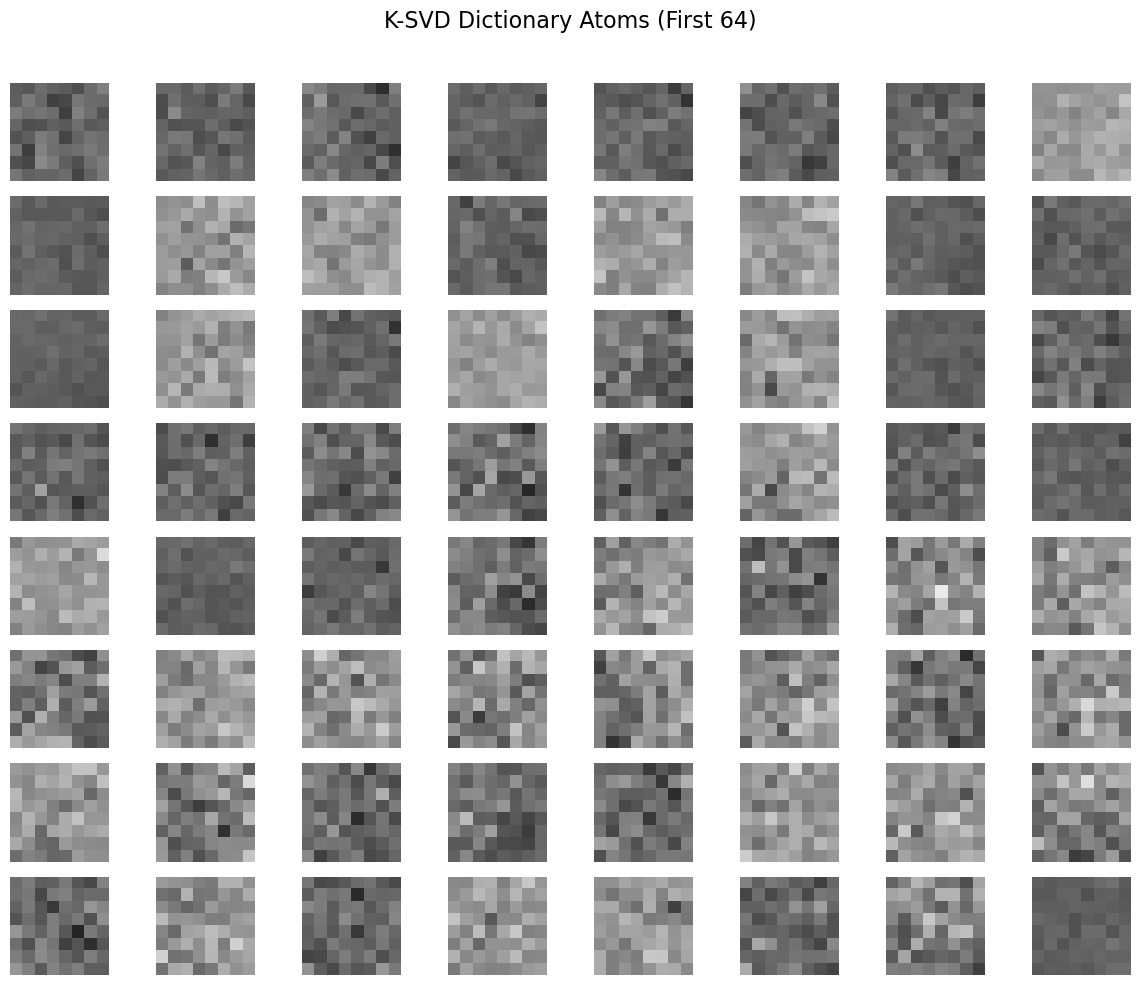

In [28]:
# Visualize the learned dictionary atoms
def visualize_dictionary(D, patch_size=8, max_atoms=64):
    n_atoms = min(D.shape[1], max_atoms)
    n_rows = int(np.sqrt(n_atoms))
    n_cols = int(np.ceil(n_atoms / n_rows))
    
    plt.figure(figsize=(12, 10))
    for i in range(n_atoms):
        plt.subplot(n_rows, n_cols, i + 1)
        atom = D[:, i].reshape(patch_size, patch_size)
        plt.imshow(atom, cmap='gray', vmin=-0.5, vmax=0.5)
        plt.axis('off')
    
    plt.suptitle('K-SVD Dictionary Atoms (First 64)', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

visualize_dictionary(learned_dictionary, patch_size=8, max_atoms=64)

## Comparison with Regular SVD Denoising

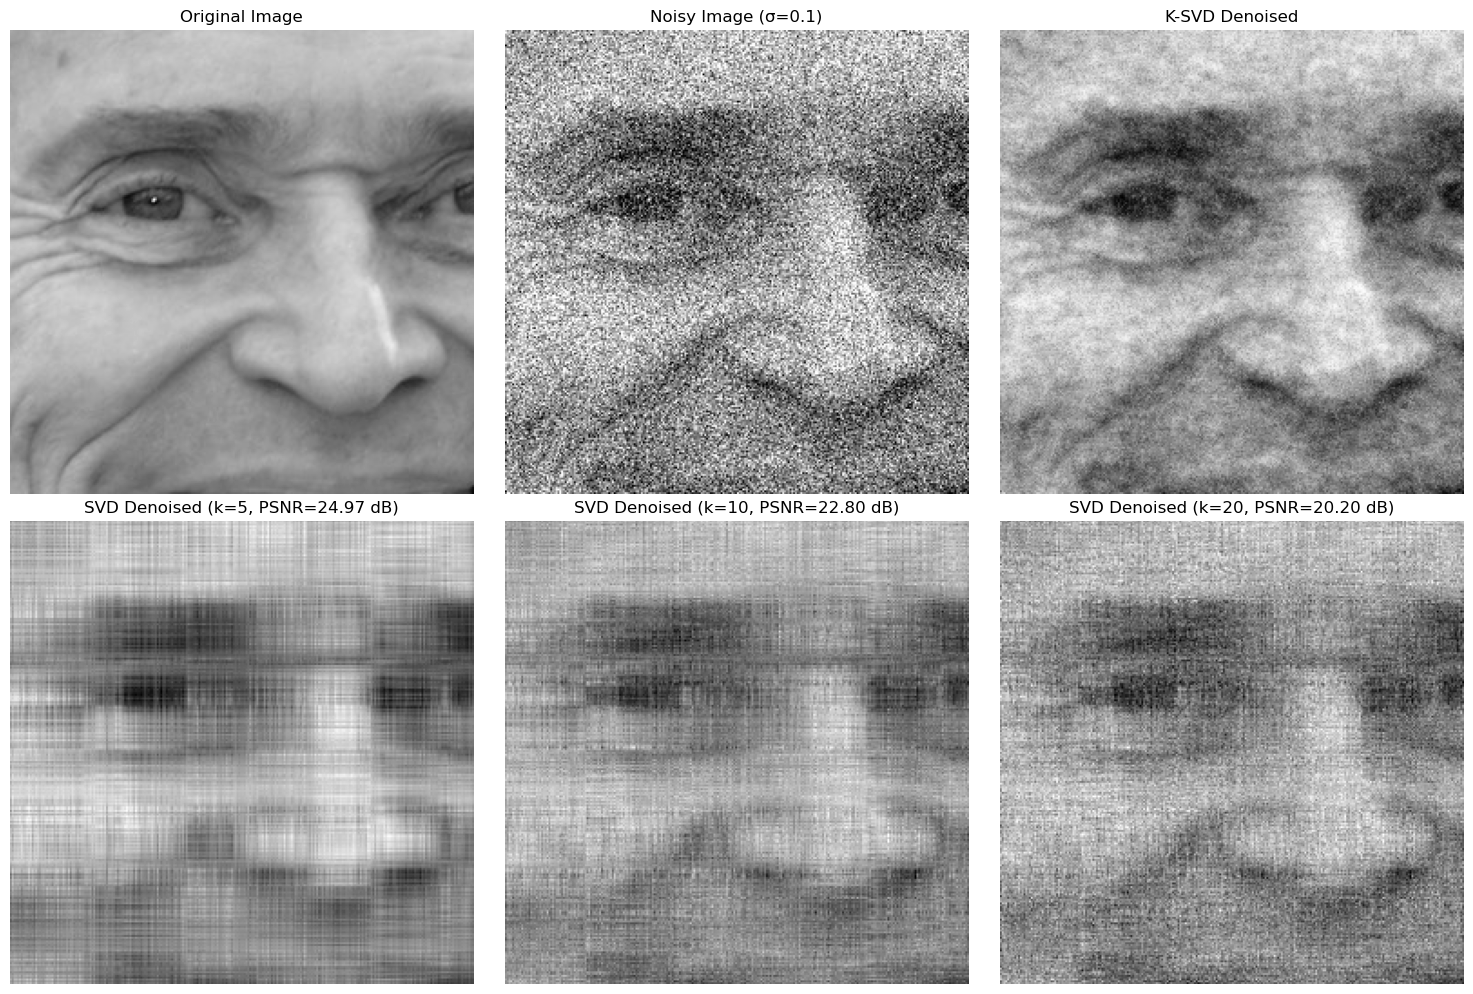

In [29]:
# Regular SVD denoising for comparison
def svd_denoise(noisy_image, k):
    """Denoise an image using regular SVD by keeping only top k singular values"""
    # Apply SVD
    U, S, Vh = np.linalg.svd(noisy_image, full_matrices=False)
    
    # Keep only top k singular values
    S_reduced = np.zeros_like(S)
    S_reduced[:k] = S[:k]
    
    # Reconstruct the denoised image
    denoised_image = U @ np.diag(S_reduced) @ Vh
    
    # Clip values to valid range
    return np.clip(denoised_image, 0, 1)

# Apply regular SVD denoising
k_values = [5, 10, 20]
plt.figure(figsize=(15, 10))

# Original and noisy images
plt.subplot(2, 3, 1)
plt.imshow(original_image_cropped, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(noisy_image_cropped, cmap='gray')
plt.title('Noisy Image (σ=0.1)')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(denoised_image, cmap='gray')
plt.title('K-SVD Denoised')
plt.axis('off')

# SVD denoising with different k values
for i, k in enumerate(k_values):
    svd_denoised = svd_denoise(noisy_image_cropped, k)
    plt.subplot(2, 3, 4 + i)
    plt.imshow(svd_denoised, cmap='gray')
    psnr = calculate_psnr(original_image_cropped, svd_denoised)
    plt.title(f'SVD Denoised (k={k}, PSNR={psnr:.2f} dB)')
    plt.axis('off')

plt.tight_layout()
plt.show()

## Conclusion: K-SVD vs. Regular SVD for Image Denoising

### Key Differences

1. **Local vs. Global Processing**:
   - Regular SVD works on the entire image as a single entity
   - K-SVD operates on small overlapping patches, capturing local patterns

2. **Adaptivity**:
   - Regular SVD uses fixed basis vectors determined by the image itself
   - K-SVD learns an adaptive dictionary specifically optimized for the image content

3. **Sparsity**:
   - Regular SVD achieves sparsity by truncating singular values
   - K-SVD explicitly enforces sparsity in patch representations

4. **Performance**:
   - K-SVD typically achieves better denoising performance, especially for textured regions
   - Regular SVD is faster but may over-smooth fine details

K-SVD excels at preserving texture and fine details while removing noise, but at the cost of higher computational complexity. Regular SVD is simpler and faster, but may struggle with complex image patterns.

Extracted 452929 patches of size 8x8
Dictionary learning iteration 1/5
Dictionary learning iteration 2/5
Dictionary learning iteration 3/5
Dictionary learning iteration 4/5
Dictionary learning iteration 5/5
K-SVD denoising completed in 1267.05 seconds.
PSNR of noisy image: 14.68 dB
PSNR of denoised image: 23.42 dB
PSNR improvement: 8.74 dB


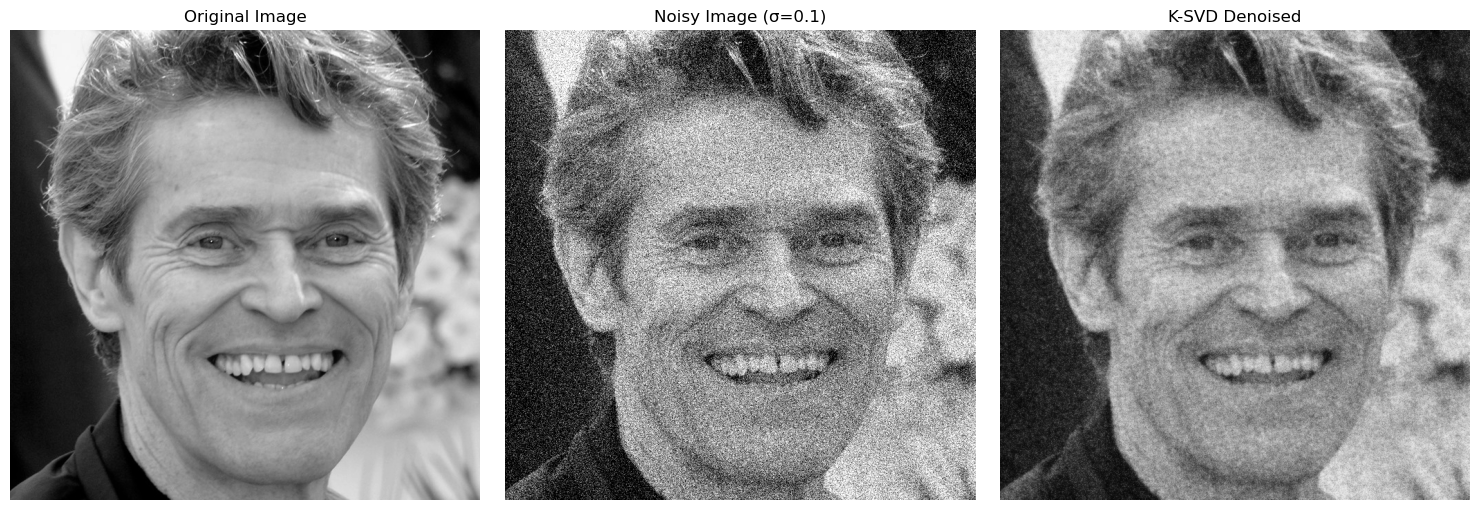

In [30]:
# For faster execution in this demo, use a smaller portion of the image
# Remove these lines if you want to process the full image
height, width = original_image.shape
crop_size = max(256, min(height, width))  # Use at most 128x128 for demo
start_h = (height - crop_size) // 2
start_w = (width - crop_size) // 2
original_image_cropped = original_image[start_h:start_h+crop_size, start_w:start_w+crop_size]
noisy_image_cropped = noisy_image[start_h:start_h+crop_size, start_w:start_w+crop_size]

# Run K-SVD denoising
denoised_image, learned_dictionary = k_svd_denoise(
    noisy_image_cropped,
    patch_size=8,
    dict_size=256,  # Reduced from 256 for faster execution
    sparsity=4,
    max_iter=5      # Reduced from 10 for faster execution
)

# Display the original, noisy, and denoised images
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(original_image_cropped, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(noisy_image_cropped, cmap='gray')
plt.title('Noisy Image (σ=0.1)')
plt.axis('off')

plt.subplot(133)
plt.imshow(denoised_image, cmap='gray')
plt.title('K-SVD Denoised')
plt.axis('off')

plt.tight_layout()

# Calculate PSNR as a quantitative measure of denoising performance
def calculate_psnr(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

psnr_noisy = calculate_psnr(original_image_cropped, noisy_image_cropped)
psnr_denoised = calculate_psnr(original_image_cropped, denoised_image)

print(f"PSNR of noisy image: {psnr_noisy:.2f} dB")
print(f"PSNR of denoised image: {psnr_denoised:.2f} dB")
print(f"PSNR improvement: {psnr_denoised - psnr_noisy:.2f} dB")